# To-do list

## Metalicty

# To look into list
Hierarchical model <br>
Varitational inference <br>
Different samplers - HMC <br>



# rotaation bv and age observers GC
# period age mass and metalictty fundemental GC


In [1]:
!pip install pymc3 --upgrade
!pip install PyAstronomy
!pip install arviz==0.11.0

Requirement already up-to-date: pymc3 in /usr/local/lib/python3.6/dist-packages (3.10.0)


In [2]:
import matplotlib.pyplot as plt
import numpy as np
import scipy

import pymc3 as pm
import theano as tt
import pandas as pd
pd.options.display.max_rows = 4000
 
from mpl_toolkits.mplot3d import Axes3D
from matplotlib  import cm
from PyAstronomy import pyasl

from google.colab import drive
from google.colab import files
drive.mount('/content/drive')

print(f"Running on PyMC3 v{pm.__version__}")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Running on PyMC3 v3.10.0


Using:  (91,)
From:  (1450, 4)


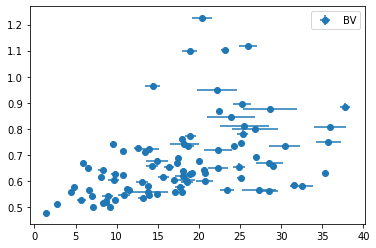

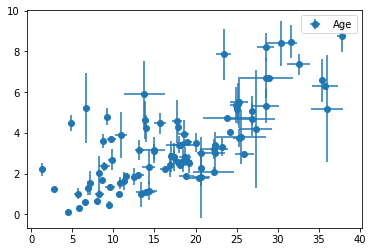

In [3]:
##### OPTIONS #####
#data1 16th points = 91 total

opt_params = 0   # if 1 use predetermined values

errorbars = 0   # plot error bars on surface plot 
smp_rt = 16     # every nth point of true data
num_gen = 400 # given n will produce n x n points of predictions


data = np.genfromtxt('/content/drive/My Drive/data/data1.csv', delimiter=',', skip_header=1)

Teff = data[:,0][0::smp_rt] # Teff
Prot = data[:, 1][0::smp_rt]  # Prot
Age = data[:, 2][0::smp_rt]  # Age 
Mass = data[:, 3][0::smp_rt]   # mass
b = pyasl.BallesterosBV_T()
BV =  b.t2bv(np.array(Teff))
#data 1 and data 2 have differnet columns! 

## Here is where I am adding some noise to the data roughly 5% for mass prot and Teff, 20% for Age

data_noise = True
n_age = 0.2
n_oth = 0.05
n_bv = 0.01

if data_noise:


  Age_err = np.random.normal(0,1, len(Age))*Age*n_age
  BV_err = np.random.normal(0,1, len(Age))*BV*n_bv

  Prot_err = np.random.normal(0,1, len(Age))*Prot*n_oth


  Age  += Age_err
  BV += BV_err
  Prot += Prot_err 

print('Using: ',Age.shape)
print('From: ',data.shape)

plt.errorbar(Prot, BV, yerr=BV_err, xerr=Prot_err, fmt='o', label='BV')
plt.legend()
plt.show()
plt.errorbar(Prot, Age, yerr=Age_err, xerr=Prot_err, fmt='o', label='Age')
plt.legend()
plt.show()


In [4]:
def mean_fn(Age, BV, A, c, h, f):
  return A * Age**c  * (BV-h)**f


https://iopscience.iop.org/article/10.1088/0004-637X/695/1/679/pdf
In this article a form is given to determine P from Bv and age that is of a slightly sifferent form to what I am currently using.
$P(t, B-V) = t^{0.52} g(B-V -h)^f$ <br>
where $g=0.77, h=0.4, f = 0.6$. I will now construct another GP using this as the mean function and see how it goes.

Im gonna sort of bash the BV dependance onto the end of my current mass, age mean function and see how it goes B). The new mean function will look like $P(t,m,(B-V)) = At^cm^d((B-V)-h)^f$. Where I a taking d from the previous GP, here A is going to be allowed to vary and the starting value will be $A^{\star}g$, where $A^{\star}$ is the A from before.  

This has resulted in considerably better results.


In [5]:
#### book ####
g = 0.77
h = 0.4 
f = 0.6 
c = 0.52 

A = 0.77




#limit = (np.where(BV<K_b))


limit = np.where((Prot>0))



BV_short = BV[limit]
Prot_short = Prot[limit]
Age_short = Age[limit]


X = np.array([Age_short, BV_short]).T 



with pm.Model() as model:
    c_ = pm.Normal('c_', c, c*0.0007)
    f_ = pm.Normal('f_', f, f*0.5)
    A_ = pm.Normal('A_', A*g, A*0.3)
  

 #   Age_true = pm.Normal('Age_true', 4, 4, shape=Age_short.shape)
    Age_true = pm.Uniform('Age_true', 0, 10, shape=Age_short.shape)
    Age_obs = pm.Normal("Age_obs", Age_true, Age_short*n_age, observed=Age_short)


    BV_true = pm.Lognormal("BV_true", 1, 1, shape=BV_short.shape )
    BV_obs = pm.Normal("BV_obs", BV_true, BV_short*n_bv, observed=BV_short)

    mean = A_* Age_true**c_    * (BV_true - h)**f_
    resid = Prot_short - mean


   


    l1 = pm.Normal('l1', mu=40, sigma=1)  # 1
    l2 = pm.Normal('l2', mu=0.05, sigma=0.01)


    sf1 = pm.Normal("sf1", 15, 1)
    sf2 = pm.Normal("sf2", 7, 0.5)



    K1 = pm.gp.cov.ExpQuad(2, l1) * sf1**2
    K2 = pm.gp.cov.ExpQuad(2, l2) * sf2**2


    K = K1 + K2 
    
    gp = pm.gp.Marginal(cov_func=K)
    x = tt.tensor.stack([Age_true, BV_true])

    obs = gp.marginal_likelihood("obs", X=X , y=resid, noise=n_oth*Prot_short)

    # big gp book says constnat plus a product of linear + white noise will do the trick
   

WARNING (theano.tensor.blas): We did not find a dynamic library in the library_dir of the library we use for blas. If you use ATLAS, make sure to compile it with dynamics library.
/usr/local/lib/python3.6/dist-packages/pymc3/sampling.py:468: FutureWarning: In an upcoming release, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  FutureWarning,
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sf2, sf1, l2, l1, BV_true, Age_true, A_, f_, c_]


Sampling 2 chains for 5_000 tune and 5_000 draw iterations (10_000 + 10_000 draws total) took 1555 seconds.


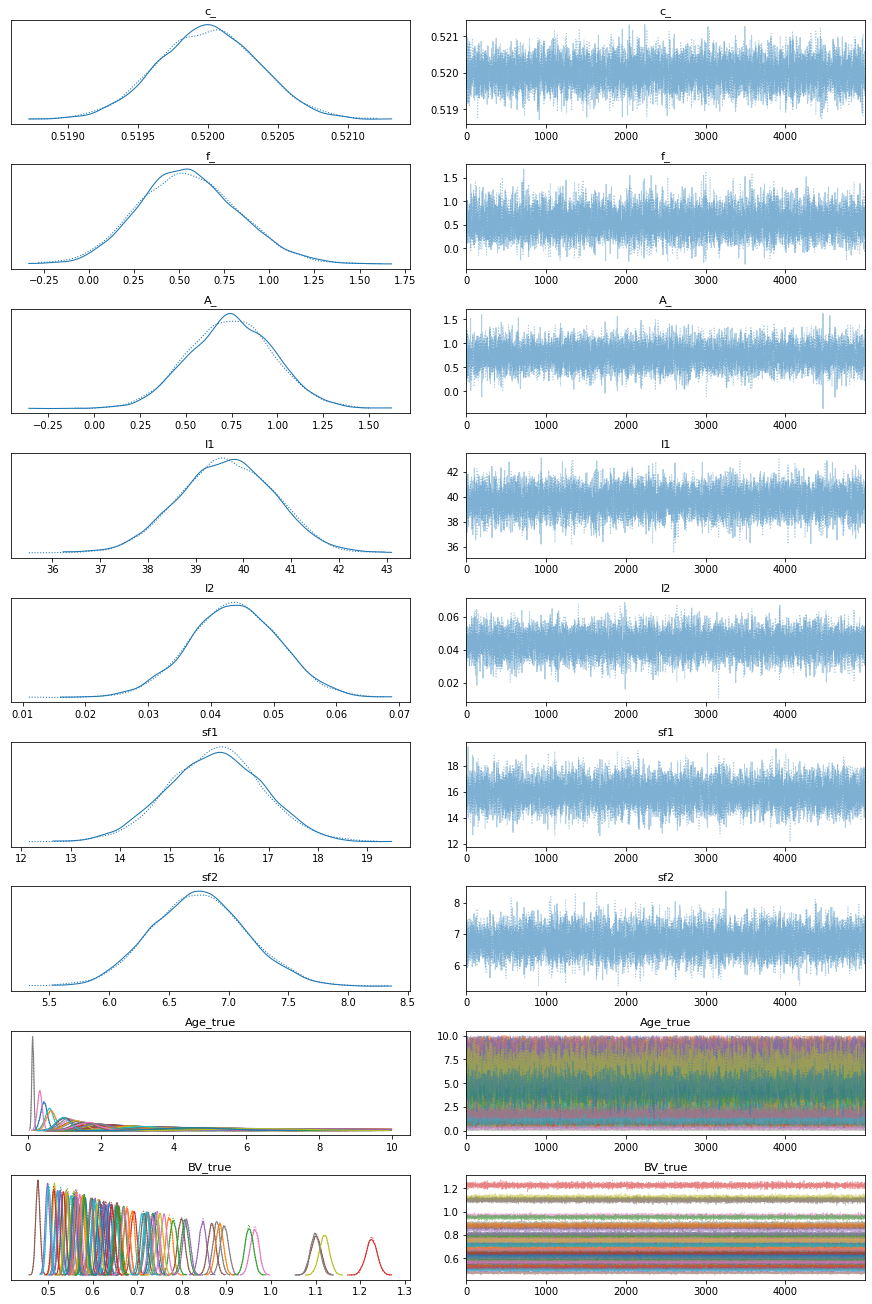

In [6]:

with model:
  trace = pm.sample(5000, tune=5000, cores=2)#, target_accept=0.95)


  pm.traceplot(trace)

In [7]:
print(pm.summary(trace))

X_pred = X

with model:
  f_pred = gp.conditional('f_pred', X_pred, pred_noise=False) # predict function
  pred_samples = pm.sample_posterior_predictive(trace, vars=[f_pred], samples=2500)

/usr/local/lib/python3.6/dist-packages/arviz/data/io_pymc3.py:92: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,


                mean     sd  hdi_3%  ...  ess_bulk  ess_tail  r_hat
c_             0.520  0.000   0.519  ...   12021.0    6681.0    1.0
f_             0.553  0.276   0.032  ...   10960.0    7049.0    1.0
A_             0.747  0.232   0.323  ...   13242.0    6616.0    1.0
l1            39.654  0.996  37.701  ...   12276.0    6879.0    1.0
l2             0.044  0.007   0.030  ...   13702.0    6472.0    1.0
sf1           15.924  0.958  14.145  ...   15392.0    7298.0    1.0
sf2            6.753  0.397   6.041  ...   14527.0    7230.0    1.0
Age_true[0]    0.446  0.090   0.279  ...    7785.0    4756.0    1.0
Age_true[1]    2.619  0.515   1.691  ...   12262.0    6060.0    1.0
Age_true[2]    2.834  0.559   1.786  ...   12701.0    6113.0    1.0
Age_true[3]    3.002  0.605   1.899  ...   15270.0    5464.0    1.0
Age_true[4]    1.694  0.330   1.055  ...   10213.0    5705.0    1.0
Age_true[5]    3.565  0.700   2.239  ...   15760.0    5879.0    1.0
Age_true[6]    1.167  0.237   0.708  ...   15038

/usr/local/lib/python3.6/dist-packages/pymc3/sampling.py:1691: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  "samples parameter is smaller than nchains times ndraws, some draws "


WARNING (theano.tensor.blas): We did not find a dynamic library in the library_dir of the library we use for blas. If you use ATLAS, make sure to compile it with dynamics library.


In [8]:


new_err = np.mean([ trace.get_values(Age_true)[:,i].std()/  trace.get_values(Age_true)[:,i].mean() for i in range(Age.shape[0])])
old_err =np.mean(np.abs(Age_err/Age))
print('Initianl error: ', old_err*100, '%')
print('New error: ', new_err*100,'%')
print("I have added {}% error :)".format(round(new_err-old_err,5)*100))



Initianl error:  18.28415287999221 %
New error:  19.78474541481382 %
I have added 1.5010000000000001% error :)


No handles with labels found to put in legend.


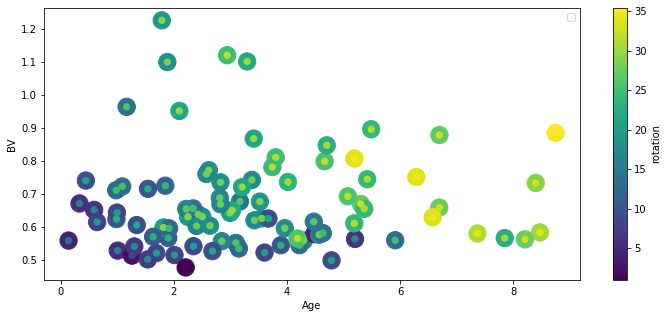

In [9]:

from matplotlib  import cm
fig = plt.figure(figsize=(12, 5))
ax = fig.gca()

from pymc3.gp.util import plot_gp_dist

#plot_gp_dist(ax, pred_samples["f_pred"], X_pred[:,0])

## plotting the predictions, make a plot of age on x axis b-v on y, plot points and colour by age

plt.scatter(X_pred[:,0], X_pred[:,1], s=300, c=np.mean(pred_samples['f_pred'],axis=0), marker = 'o', cmap = cm.viridis)
plt.xlabel('Age')
plt.ylabel('BV')
plt.colorbar(label='rotation')
plt.scatter(Age, BV, c=np.log(Prot), s=40, cmap = cm.viridis)
plt.legend()
plt.show()

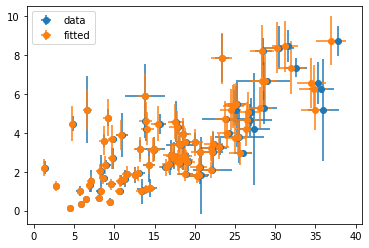

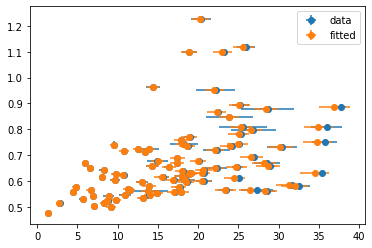

In [49]:
A = np.mean(trace['A_'])
c = np.mean(trace['c_'])
h = h
f = np.mean(trace['f_'])

mean = mean_fn(X_pred[:,0], X_pred[:,1], A, c ,h,f)

fit = (np.mean(pred_samples['f_pred'],axis=0))


mu = fit + mean
var = (np.var(pred_samples['f_pred'], axis=0))








age_fit_err = [trace.get_values(Age_true)[:,i].std() for i in range(trace.get_values(Age_true).shape[1])]
bv_fit_err = [trace.get_values(BV_true)[:,i].std() for i in range(trace.get_values(BV_true).shape[1])]



plt.errorbar(Prot, Age, yerr=Age_err, xerr=Prot_err, fmt='o', label='data')
plt.errorbar(mu, X[:,0], xerr=np.sqrt(var), yerr=age_fit_err, fmt='o', label='fitted')
plt.legend()
plt.show()


plt.errorbar(Prot, BV, yerr=BV_err, xerr=Prot_err, fmt='o', label='data')
plt.errorbar(mu, X[:,1],xerr=np.sqrt(var), yerr=bv_fit_err, fmt='o', label='fitted')
plt.legend()
plt.show()


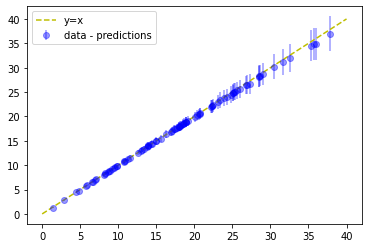

[0.05456531 0.06479091 0.08482644 0.09035255 0.12127448 0.13334914
 0.15832182 0.17860078 0.17991048 0.21189956 0.22941673 0.24923369
 0.26087524 0.26454533 0.27155999 0.27168531 0.31496391 0.31747964
 0.33527689 0.34002779 0.35502764 0.37589595 0.3784992  0.38044589
 0.40165979 0.4396327  0.46427093 0.47220242 0.49667142 0.50126022
 0.53749689 0.56830745 0.60766419 0.65604437 0.66182649 0.67984699
 0.68058275 0.6887784  0.72641188 0.75550485 0.77632179 0.79747171
 0.81727437 0.85306546 0.85979482 0.89416811 0.90806688 0.91674593
 0.93310771 0.93367217 0.94295884 0.95243046 0.9788466  0.98087276
 0.98345294 1.01916212 1.03091751 1.04648927 1.0657102  1.11800966
 1.12246954 1.12834816 1.28700853 1.29987578 1.31821304 1.32881486
 1.45639708 1.57699246 1.59589297 1.66033761 1.6813452  1.68209897
 1.71809855 1.72482655 1.74298619 1.75815831 1.76544084 1.88931511
 1.97495147 1.9937824  2.15644875 2.19859558 2.2192207  2.28887571
 2.53897609 2.67191308 2.87670349 3.18971075 3.24367226 3.2808

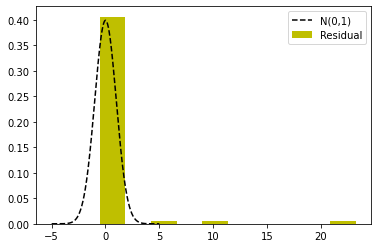

In [48]:
vals = np.sort([mu, var, Prot_short], axis=1)

plt.plot([0, 40], [0, 40], linestyle='--', label='y=x', color='y')
plt.errorbar(np.sort(Prot_short), vals[0,:], yerr=vals[1,:], fmt='o', label=r'data - predictions', color='b', alpha=0.4)
plt.savefig("R0_2.png")
files.download("R0_2.png") 
plt.legend()
plt.show()


print(vals[1,:])
print(np.sort(sd))
var = (np.var(pred_samples['f_pred'], axis=0))

Z = (vals[2,:] - vals[0, :])/(vals[1,:]**2)


print()
x = np.linspace(-5,5, 1000)
f = 1/np.sqrt(2 * np.pi) * np.exp(-1/2 * x**2) #N(0,1) to compare with Z 

plt.hist(Z, density=True, label='Residual', color='y')
 
plt.plot(x,f, label='N(0,1)', color='k', linestyle='--')
txt="Figure 2: The residuals of the difference betwen the predictions and the true data, normalised by the standard devition. If this was perfect, it would be a fit a N(0,1) distribution"
#plt.figtext(0.5, 0.01, txt, wrap=True, horizontalalignment='center', fontsize=12)

plt.legend()

plt.savefig("H0_2.png")
files.download("H0_2.png") 
plt.show()

These two plots are evidence that this model does fit the data very well. We can use the parameters and hyper parameters gathered here for future GP implementations on true data. 

Second fast component t the gp when we dont have B-V